This notebook will analyze various datasets with regards to minority representation across various industries, with an additional focus on STEM fields. The primary goal is to find discrepancies in representative statistics between the raw data and those yielded from data mining algorithms.

The following historical data will be used to illustrate differences between the proportions of racially-classified "professionals" (college graduates) against the race-based percentage of the population in 2011 (the year chosen as this had the most complete employment records across all industries). The ratios of professionals is taken from the United States Equal Employment Opportunity Commission's statistics on employees across all industries in all 51 states/territories, while the race-based percentages of the population are calculated from United States Census records.

This is not meant to demonstrate data mining techniques, but rather to provide some historical background on race-based discrepancies in hiring.

In [117]:
import numpy as np
import pandas as pd
from tqdm import tqdm

cols = ['State', 'nac2Label', 'totProf/StInd',  
        'whiteProfessionalTotal', 'blackProfessionalTotal', 'hispanicOrLatinoProfessionalTotal', 
        'asianProfessionalTotal', 'americIndianProfessionalTotal', 'pacificIslanderProfessionalTotal']

df = pd.read_csv("inputs/CountByStateAndIndustryNAC-2.csv", usecols=cols, nrows=957)

df = df.loc[(df['nac2Label'] == 'Information') | (df['nac2Label'] == 'Professional, Scientific, and Technical Services')]

df = df.drop(columns=['nac2Label'])

df = df.groupby('State', sort=True).sum(numeric_only=True)

df = df.rename(columns={'totProf/StInd': 'Total Professionals', 'whiteProfessionalTotal': 'White Professionals',
                       'blackProfessionalTotal': 'Black Professionals', 'hispanicOrLatinoProfessionalTotal': 'Hispanic Professionals',
                       'asianProfessionalTotal': 'Asian Professionals', 'americIndianProfessionalTotal': 'American Indian Professionals',
                       'pacificIslanderProfessionalTotal': 'Pacific Islander Professionals'})

df

,Total Professionals,White Professionals,Black Professionals,Hispanic Professionals,Asian Professionals,American Indian Professionals,Pacific Islander Professionals
State,,,,,,,
Alabama,62826,52011,4182,3467,755,2167,38
Alaska,2827,2381,156,103,65,82,13
Arizona,22336,16609,787,2030,2417,151,76
Arkansas,5834,4658,436,94,561,21,6
California,277600,156349,8761,20929,84493,835,1531
Colorado,51776,43086,1501,2921,3335,210,105
Connecticut,21139,16107,979,810,3061,35,27
Delaware,2858,2132,285,76,321,6,6
District of Columbia,36907,26005,4790,1441,4011,79,67


In [118]:
true_prop_2011 = np.array([.628, .123, .169, .049, .007, .002]) # Adapted from non-CSV charts of 2011 population estimates

np.set_printoptions(precision=5, suppress=True)
state_profs = df.values[:,1:7].astype(float)
state_totals = df.values[:,0]

total_prof = state_totals.sum()

prop = np.zeros((6)).astype(float)

for i in range(state_profs.shape[1]):
    prop[i] = state_profs[:, i].sum() / total_prof

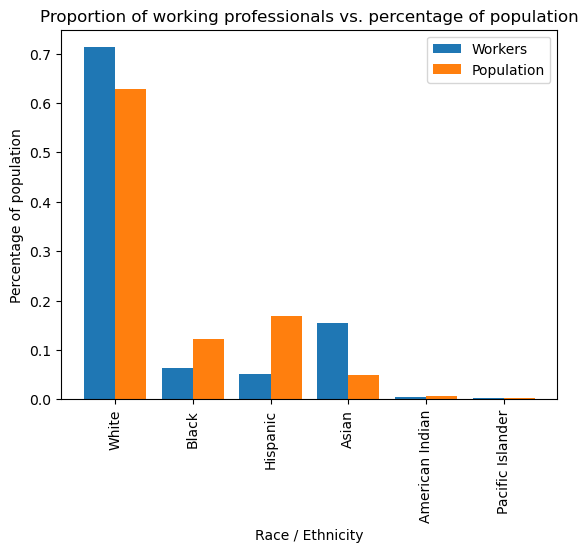

In [119]:
import matplotlib.pyplot as plt

X = ['White', 'Black', 'Hispanic', 'Asian', 'American Indian', 'Pacific Islander']

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, prop, 0.4, label = 'Workers')
plt.bar(X_axis + 0.2, true_prop_2011, 0.4, label = 'Population')

plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Race / Ethnicity")
plt.ylabel("Percentage of population")
plt.title("Proportion of working professionals vs. percentage of population")
plt.legend()

plt.show()

The disparities shown above, although limited in scope to what the EEOC was able to quantify, does seem to demonstrate that white graduates are oversampled across the totality of the data's STEM related fields, while black and Hispanic candidates are extremely undersampled. A key difference is in the additional oversampling of Asian college graduates in the workforce, one that we will revisit later on.

In [199]:
import seaborn as sns

df = pd.read_csv('inputs/HRDataset_v13.csv')
df.dropna(how='all', inplace=True)
df.RaceDesc.name = 'Racial Group'
display(df.RaceDesc.value_counts(), df.RaceDesc.value_counts(normalize=True) * 100)

White                               193
Black or African American            57
Asian                                34
Two or more races                    18
American Indian or Alaska Native      4
Hispanic                              4
Name: Racial Group, dtype: int64

White                               62.258065
Black or African American           18.387097
Asian                               10.967742
Two or more races                    5.806452
American Indian or Alaska Native     1.290323
Hispanic                             1.290323
Name: Racial Group, dtype: float64

Next we will isolate only the purely quantitative features of the dataset regarding each employee, including a race-based ground truth label. In addition, we will only examine "Active" employees, as the other statuses were too few and far between to make any real statistical impact through analysis.

In [200]:
df = df[df['EmploymentStatus'] == 'Active']
relevant_info = ['RaceDesc', 'GenderID',
                 'PerfScoreID', 'EngagementSurvey']
display(df[relevant_info])

,RaceDesc,GenderID,PerfScoreID,EngagementSurvey
0,Black or African American,0.0,3.0,2.04
1,Black or African American,1.0,3.0,5.00
2,White,1.0,3.0,3.90
4,White,0.0,3.0,5.00
7,White,0.0,3.0,5.00
...,...,...,...,...
298,White,1.0,3.0,3.84
299,White,0.0,3.0,5.00
300,Asian,0.0,3.0,5.00
308,White,1.0,3.0,5.00


For classification purposes, each of the recorded racial groups will be coded to an integer value.

In [201]:
df.replace('Black or African American', 0.0, inplace=True)
df.replace('White', 1.0, inplace=True)
df.replace('Asian', 2.0, inplace=True)
df.replace('Hispanic', 3.0, inplace=True)
df.replace('Two or more races', 4.0, inplace=True)
df.replace('American Indian or Alaska Native', 5.0, inplace=True)
display(df[relevant_info])

,RaceDesc,GenderID,PerfScoreID,EngagementSurvey
0,0.0,0.0,3.0,2.04
1,0.0,1.0,3.0,5.00
2,1.0,1.0,3.0,3.90
4,1.0,0.0,3.0,5.00
7,1.0,0.0,3.0,5.00
...,...,...,...,...
298,1.0,1.0,3.0,3.84
299,1.0,0.0,3.0,5.00
300,2.0,0.0,3.0,5.00
308,1.0,1.0,3.0,5.00


Next, we will separate the features from the number-coded ground truth labels, and then partition each in the same manner into training and validation sets in a 4 to 1 ratio.

In [202]:
features = df[relevant_info].values[:, 1:4]
labels = df[relevant_info].values[:, 0].astype(int)
print('array of labels: shape ' + str(np.shape(labels)))
print('array of feature matrix: shape ' + str(np.shape(features)))

array of labels: shape (182,)
array of feature matrix: shape (182, 3)


In [203]:
val_features, train_features = np.split(features, [int(0.2 * features.shape[0])])

val_labels, train_labels = np.split(labels, [int(0.2 * labels.shape[0])])

print(np.shape(train_features))
print(np.shape(val_features))

print(np.shape(train_labels))
print(np.shape(val_labels))

(146, 3)
(36, 3)
(146,)
(36,)


We will now perform a KNN algorithm to the data, using the 2 nearest neighbors as a baseline to start.

In [204]:
def KNN(train_features, train_labels, test_features, k=2):
    preds = []
    for i in tqdm(range(test_features.shape[0])):
        dist = np.sum(np.square(test_features[i] - train_features), axis=1)
        near_ind = np.argpartition(dist, k)[:k]
        near_lab = list(train_labels[near_ind])
        pred = max(near_lab, key=near_lab.count)
        preds.append(pred)
    return np.array(preds)

val_preds = KNN(train_features, train_labels, val_features)
print(val_preds.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 35755.37it/s]

(36,)


In [205]:
def evaluation(true, pred):
    acc = np.sum(pred == true) / len(true)

    micro_TP = 0
    micro_FP = 0
    micro_FN = 0
    micro_TN = 0
    macro_F1 = []

    for c in range(6):
        c_label_pos = (true == c)
        c_label_neg = ~c_label_pos
        c_pred_pos = (pred == c)
        c_pred_neg = ~c_pred_pos

        TP = np.sum(c_label_pos * c_pred_pos)
        FP = np.sum(c_label_neg * c_pred_pos)
        FN = np.sum(c_label_pos * c_pred_neg)
        TN = np.sum(c_label_neg * c_pred_neg)

        if TP == 0:
            precision = 0
            recall = 0
            F1 = 0
        else:
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            F1 = 2 * precision * recall / (precision + recall)
        macro_F1.append(F1)

        micro_TP += TP
        micro_FP += FP
        micro_TN += TN
        micro_FN += FN

    macro_F1 = np.mean(macro_F1)
    micro_precision = micro_TP / (micro_TP + micro_FP)
    micro_recall = micro_TP / (micro_TP + micro_FN)
    micro_F1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall)

    print('accuracy = %.6f' % acc)
    print('macro F1 = %.6f' % macro_F1)
    print('micro F1 = %.6f' % micro_F1)
    
evaluation(val_labels, val_preds)

accuracy = 0.388889
macro F1 = 0.192761
micro F1 = 0.388889


The purely quantitative metrics yield classification results that are evidently very poor predictors for racial identity. However, this is not enough to say that there is a systemic problem in and of itself given that this is simulated data of comparatively small size. The discussion will likely be more fruitful by examining a much larger real world dataset with more scalable values. The following dataset is acquired from a large repository concerned with salaries in data science and other STEM fields. Given that this dataset included a very significant proportion of null responses, they will be treated as "unknown" in the following aggregation, but will be removed later. This is an unfortunate consequence but necessary given the analysis is focused on known identifiers.

In [273]:
df = pd.read_csv('inputs/Levels_Fyi_Salary_Data.csv')
df = df[['gender', 'Race', 'company', 'title', 'yearsofexperience', 
         'yearsatcompany', 'Education', 'totalyearlycompensation']]
df = df.fillna({'gender':'Unknown', 'Race':'Unknown', 'company':'Unknown', 'Education':'Unknown'})
df = df.rename(columns = {'gender':'Gender', 'company':'Company', 'title':'Position', 
                          'yearsofexperience':'Years of Experience', 'yearsatcompany':'Years at Company', 
                          'totalyearlycompensation':'Annual Compensation'})
display(df)
df['Position'].unique()

,Gender,Race,Company,Position,Years of Experience,Years at Company,Education,Annual Compensation
0,Unknown,Unknown,Oracle,Product Manager,1.5,1.5,Unknown,127000
1,Unknown,Unknown,eBay,Software Engineer,5.0,3.0,Unknown,100000
2,Unknown,Unknown,Amazon,Product Manager,8.0,0.0,Unknown,310000
3,Unknown,Unknown,Apple,Software Engineering Manager,7.0,5.0,Unknown,372000
4,Unknown,Unknown,Microsoft,Software Engineer,5.0,3.0,Unknown,157000
...,...,...,...,...,...,...,...,...
62637,Unknown,Unknown,Google,Software Engineer,10.0,1.0,Unknown,327000
62638,Unknown,Unknown,Microsoft,Software Engineer,2.0,2.0,Unknown,237000
62639,Unknown,Unknown,MSFT,Software Engineer,14.0,12.0,Unknown,220000
62640,Unknown,Unknown,Salesforce,Software Engineer,8.0,4.0,Unknown,280000


array(['Product Manager', 'Software Engineer',
       'Software Engineering Manager', 'Data Scientist',
       'Solution Architect', 'Technical Program Manager',
       'Human Resources', 'Product Designer', 'Marketing',
       'Business Analyst', 'Hardware Engineer', 'Sales', 'Recruiter',
       'Mechanical Engineer', 'Management Consultant'], dtype=object)

After this postprocessing, the unique positions informs us that there are non-STEM and CS-related occupations we can remove. We will keep any positions that can tenuously be linked to a CS or STEM field.

In [274]:
df = df[(df['Position'].str.contains('Human Resources') == False)]
df = df[(df['Position'].str.contains('Marketing') == False)]
df = df[(df['Position'].str.contains('Business Analyst') == False)]
df = df[(df['Position'].str.contains('Sales') == False)]
df = df[(df['Position'].str.contains('Recruiter') == False)]
display(df)

,Gender,Race,Company,Position,Years of Experience,Years at Company,Education,Annual Compensation
0,Unknown,Unknown,Oracle,Product Manager,1.5,1.5,Unknown,127000
1,Unknown,Unknown,eBay,Software Engineer,5.0,3.0,Unknown,100000
2,Unknown,Unknown,Amazon,Product Manager,8.0,0.0,Unknown,310000
3,Unknown,Unknown,Apple,Software Engineering Manager,7.0,5.0,Unknown,372000
4,Unknown,Unknown,Microsoft,Software Engineer,5.0,3.0,Unknown,157000
...,...,...,...,...,...,...,...,...
62637,Unknown,Unknown,Google,Software Engineer,10.0,1.0,Unknown,327000
62638,Unknown,Unknown,Microsoft,Software Engineer,2.0,2.0,Unknown,237000
62639,Unknown,Unknown,MSFT,Software Engineer,14.0,12.0,Unknown,220000
62640,Unknown,Unknown,Salesforce,Software Engineer,8.0,4.0,Unknown,280000


The "unknown" monikers will be of little use, so any samples with said values in the dataframe in columns that are about to be examined will be culled. In the following cell, a one-hot encoding for gender will be added to replace the 'gender' column in the dataframe, and will also remove any non-binary identifiers for simplicity.

In [275]:
one_hot_gender = pd.get_dummies(df['Gender'])
df_sex = df.drop('Gender', axis = 1)
df_sex = one_hot_gender.join(df_sex)
df_sex = df_sex[(df_sex['Male'] == 1) | (df_sex['Female'] == 1)]
df_sex = df_sex.drop('Other', axis = 1)
df_sex = df_sex.drop('Title: Senior Software Engineer', axis = 1)
df_sex = df_sex.drop('Unknown', axis = 1)
df_sex = df_sex[['Male', 'Female', 'Years of Experience', 'Years at Company', 'Annual Compensation']]
df_sex

,Male,Female,Years of Experience,Years at Company,Annual Compensation
264,1,0,4.0,4.0,140000
265,1,0,12.0,2.0,172000
266,1,0,7.0,2.0,325000
269,1,0,4.0,0.0,150000
270,1,0,11.0,4.0,640000
...,...,...,...,...,...
62610,1,0,1.0,0.0,135000
62611,1,0,14.0,1.0,350000
62612,0,1,20.0,2.0,305000
62613,1,0,3.0,0.0,152000


The relevant features have been selected. Before attempting to find a linear regression model, however, it may be useful to try and find any discernible patterns through simpler visual means first to inform our understanding. Let's try graphing the relationship between years of experience and compensation separately for men and women.

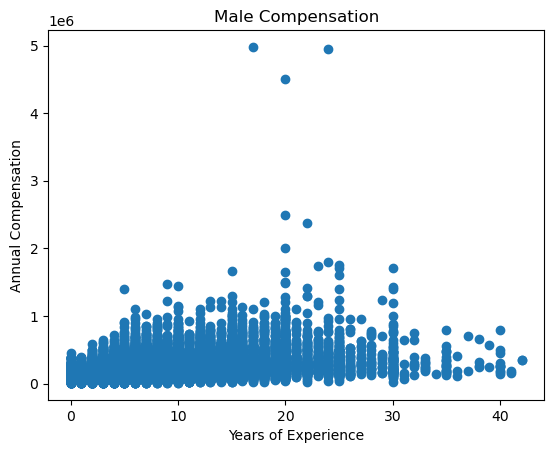

Number of males: 34749


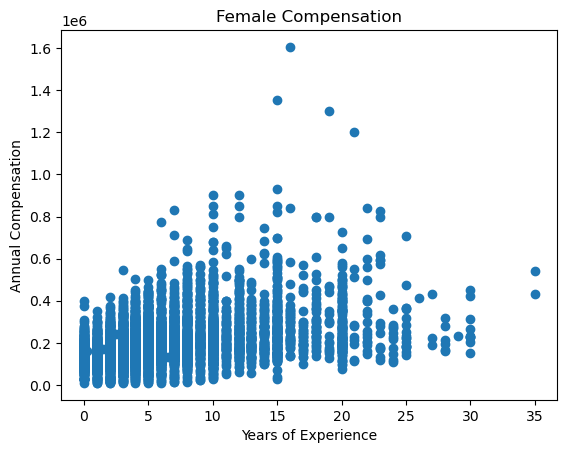

Number of females: 6252


In [276]:
df_show = df_sex[df_sex['Male'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('Male Compensation')
plt.show()
print('Number of males: ' + str(df_show.shape[0]))

df_show = df_sex[df_sex['Female'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('Female Compensation')
plt.show()
print('Number of females: ' + str(df_show.shape[0]))

There does not seem to be a purely visible correlation between genders and pay, and no real relationship within genders and years of experience. In fact, female compensation across all years of experience seems to trend higher, but this could be a result of there being so fewer declared females compared to males. With this context, we can proceed with a linear regression model that will be trained using the Ordinary Least Squares (OLS) method using 5-fold cross validation to minimize the residual sum of squares error (RSS). Then, the weights associated with the minimum RSS will be used to predict compensation across all samples.

In [277]:
# Function assumes that the dependent variable (labels, y, etc.) is the final column of the array
def ols(data, folds=5):
    x_num = data.shape[1] - 1
    x_train, y_train = data.values[:, :x_num], data.values[:, -1]

    features = x_train.astype(float)
    labels = y_train.astype(float)
    
    features_split = np.array_split(features, folds)
    labels_split = np.array_split(labels, folds)

    w_models = []
    rss_errors = np.zeros(5).astype(float)

    for i in range(folds):
        old_x = features_split[i]
        x = np.ones(shape=(old_x.shape[0], old_x.shape[1] + 1)) # Array of ones with one additional column for base weight
        x[:, 1:] = old_x # Replace non-first columns with features
        y = labels_split[i]
        xt = np.transpose(x) # X^T
        xty = np.dot(xt, y) # X^T * y
        xtx = np.dot(xt, x) # X^T * X
        xtx_1 = np.linalg.pinv(xtx) # (X^T * X)^-1
        w = np.dot(xtx_1, xty) # (X^T * X)^-1 * (X^T * y)
        w_models.append(w)

        # Isolate validation set for RSS calcs
        # x = features[start:end]
        # y = labels[start:end]
        y_xw = y - (np.dot(x, w)) # y - Xw
        y_xw_t = np.transpose(y_xw) # (y - Xw)^T
        rss_w = np.dot(y_xw_t, y_xw) # (y - Xw)^T * (y - Xw)

        sqrt_rss_w = rss_w ** (1/2) # sqrt of RSS
        rss_errors[i] = sqrt_rss_w
        print('The square root RSS of fold ' + str(i + 1) + ' = ' + str(rss_errors[i]))

    min_arg = np.argmin(rss_w)
    min_w = w_models[min_arg]
    return min_w, x_train

# Simple matrix multiplication to apply calculated weights to samples and yield predicted y
def get_preds(weights, features):
    n, d = features.shape
    d_plus_one = d + 1
    
    aug_features = np.ones(shape=(n, d_plus_one))
    aug_features[:, 1:] = features
    
    return np.dot(aug_features, weights)

weights, features = ols(df_sex, 5)

print("The weights used for the predicted salary are: " + str(weights))

df_sex['Predicted Compensation'] = get_preds(weights, features)
df_sex

The square root RSS of fold 1 = 10230313.849716265
The square root RSS of fold 2 = 10161329.195622012
The square root RSS of fold 3 = 9800290.534871018
The square root RSS of fold 4 = 10753157.883908376
The square root RSS of fold 5 = 13980803.223955039
The weights used for the predicted salary are: [108369.84871  57425.51618  50944.33253  10002.95321  -1561.86543]


,Male,Female,Years of Experience,Years at Company,Annual Compensation,Predicted Compensation
264,1,0,4.0,4.0,140000,199559.716011
265,1,0,12.0,2.0,172000,282707.072548
266,1,0,7.0,2.0,325000,232692.306500
269,1,0,4.0,0.0,150000,205807.177732
270,1,0,11.0,4.0,640000,269580.388478
...,...,...,...,...,...,...
62610,1,0,1.0,0.0,135000,175798.318103
62611,1,0,14.0,1.0,350000,304274.844398
62612,0,1,20.0,2.0,305000,356249.514572
62613,1,0,3.0,0.0,152000,195804.224522


There seems to be a much larger effect by sex on compensation than years of experience. Moreover, the number of years spent at a company seems to be slightly negatively correlated overall. This may be because of the high rate of turnover that is common in the tech industry making this metric particularly unhelpful. While it is unfortunate that there aren't more "objective" qualifiers, this does seem to indicate that gender weighs too heavily on predicting compensation.

Next we can repeat this analyses through the lens of race.

In [278]:
one_hot_race = pd.get_dummies(df['Race'])
df_race = df.drop('Race', axis = 1)
df_race = one_hot_race.join(df_race)
df_race = df_race[(df_race['White'] == 1) | (df_race['Black'] == 1)
                 | (df_race['Asian'] == 1) | (df_race['Hispanic'] == 1)]
df_race = df_race.drop('Unknown', axis = 1)
df_race = df_race.drop('Two Or More', axis = 1)
df_race = df_race[['White', 'Black', 'Asian', 'Hispanic', 'Years of Experience', 'Years at Company', 'Annual Compensation']]
df_race

,White,Black,Asian,Hispanic,Years of Experience,Years at Company,Annual Compensation
6921,1,0,0,0,7.0,2.0,310000
8366,0,0,1,0,14.0,3.0,200000
10937,0,1,0,0,2.0,1.0,103000
11997,0,0,1,0,6.0,2.0,170000
14429,0,0,1,0,1.0,1.0,134000
...,...,...,...,...,...,...,...
61982,0,0,1,0,20.0,14.0,4500000
61984,1,0,0,0,16.0,2.0,1605000
61986,0,0,1,0,15.0,15.0,1660000
61987,0,1,0,0,22.0,2.0,2372000


Let's repeat the simplistic analysis through the known single race classifiers.

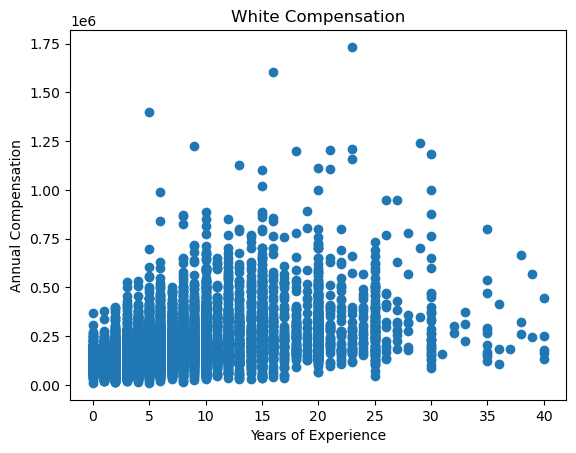

Number of white employees: 7334


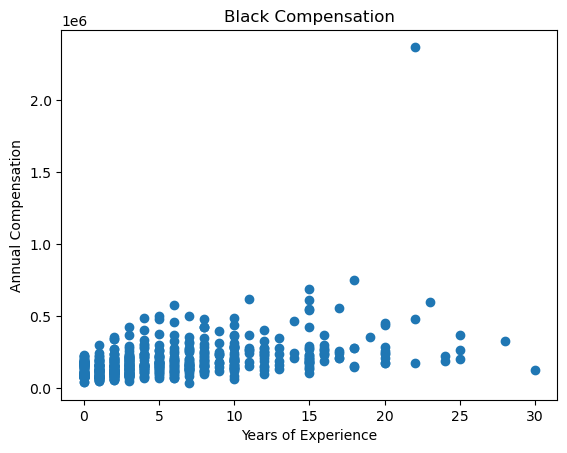

Number of black employees: 585


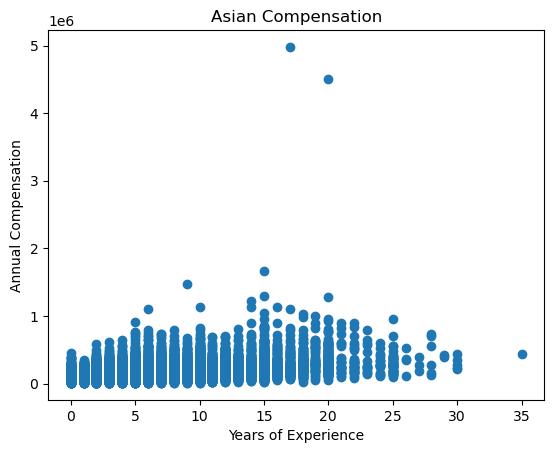

Number of asian employees: 11286


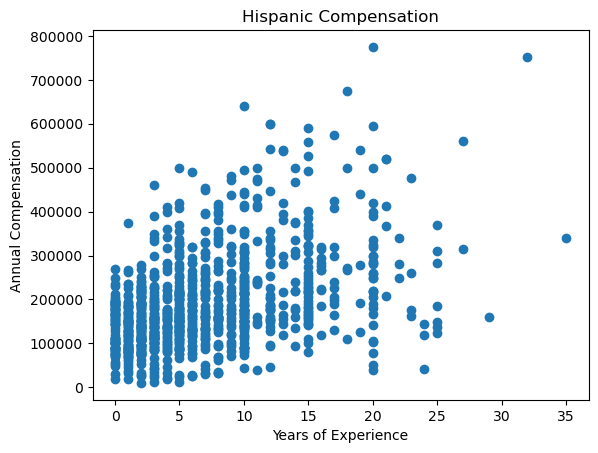

Number of hispanic employees: 1027


In [283]:
df_show = df_race[df_race['White'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('White Compensation')
plt.show()
print('Number of white employees: ' + str(df_show.shape[0]))

df_show = df_race[df_race['Black'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('Black Compensation')
plt.show()
print('Number of black employees: ' + str(df_show.shape[0]))

df_show = df_race[df_race['Asian'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('Asian Compensation')
plt.show()
print('Number of asian employees: ' + str(df_show.shape[0]))

df_show = df_race[df_race['Hispanic'] == 1]
plt.scatter(df_show['Years of Experience'], df_show['Annual Compensation'])
plt.xlabel('Years of Experience')
plt.ylabel('Annual Compensation')
plt.title('Hispanic Compensation')
plt.show()
print('Number of hispanic employees: ' + str(df_show.shape[0]))

Again, there is little correlation here between the only truly objective metric available in this data set. We must proceed with linear regression to identify which features weigh the most on predicting compensation.

In [272]:
weights, features = ols(df_race, 5)

print("The weights used for the predicted salary are: " + str(weights))

df_race['Predicted Compensation'] = get_preds(weights, features)
df_race

The square root RSS of fold 1 = 6597671.769673452
The square root RSS of fold 2 = 7273812.096894779
The square root RSS of fold 3 = 7545130.4002894275
The square root RSS of fold 4 = 7177795.523931113
The square root RSS of fold 5 = 10125665.286987683
The weights used for the predicted salary are: [114346.26376  28983.65744  32572.50561  35057.71418  17732.38652
   9038.66236  -3784.53103]


,White,Black,Asian,Hispanic,Years of Experience,Years at Company,Annual Compensation,Predicted Compensation
6921,1,0,0,0,7.0,2.0,310000,199031.495689
8366,0,0,1,0,14.0,3.0,200000,264591.657937
10937,0,1,0,0,2.0,1.0,103000,161211.563074
11997,0,0,1,0,6.0,2.0,170000,196066.890066
14429,0,0,1,0,1.0,1.0,134000,154658.109281
...,...,...,...,...,...,...,...,...
61982,0,0,1,0,20.0,14.0,4500000,277193.790803
61984,1,0,0,0,16.0,2.0,1605000,280379.456951
61986,0,0,1,0,15.0,15.0,1660000,228215.947962
61987,0,1,0,0,22.0,2.0,2372000,338200.279295


Again, years at a company seems to have a slight negative correlation, and years of experience seems to have little bearing in comparison to the other racial qualifiers. Again, the racial identifiers seem to have too much weight in this relationship.